## 서비스 소개
1. **어떤 서비스**인가요?
    1. 10대 청소년을 대상으로 한 “익명 투표” 모바일 애플리케이션입니다.
    2. 사용자는 학교, 학년, 반을 선택하여 가입한 후, “무계획 여행을 떠났을 때 가장 재밌을 것 같은 사람은?”, “주변 사람들을 제일 많이 챙겨주는 사람은?” 등과 같은 질문에 익명으로 투표할 수 있습니다.

2. 앱 내부에 **어떤 기능이** 있나요?
    - **가입 및 프로필 설정**: 사용자는 앱을 다운로드한 후, 본인 명의의 휴대폰 번호로 인증을 진행하고, 학교, 학년, 반 등의 정보를 입력하여 가입합니다. 이 과정에서 연락처에 있는 같은 학교 친구들이 자동으로 연동되며, 알 수도 있는 친구들을 추천받을 수 있습니다.     

    - **질문 및 투표 참여**: 사용자는 사전에 제작되어 랜덤으로 제시되는 질문에 대해 가장 잘 맞는 친구를 선택하여 투표할 수도 있습니다. 투표는 익명으로 이루어지며, 선택된 친구는 자신이 어떤 질문에 선택되었는지 알 수 있습니다. 질문은 연속으로 10개가 제시되며, 답변하기 싫거나 하기 어려운 것들은 중간중간 스킵할 수 있습니다.    

    - **투표 확인 및 힌트 사용**: 자신이 받은 투표는 알림으로 확인할 수 있으며, 포인트(하트)를 사용하여 자신을 선택한 사람의 초성을 확인할 수 있습니다. 이러한 힌트 기능을 통해 누가 자신을 선택했는지 추측할 수 있습니다.    

    - **친구 추가 및 상호작용**: 앱 내에서 친구를 추가하거나, 친구로부터 받은 투표에 답장하는 등의 상호작용이 가능합니다.     

    - **타임라인** : 친구들이 받은 투표들을 확인할 수 있는 탭입니다.    
    
    - **친구 추천** : 같은 학교거나, 알 수도 있는 친구들의 목록을 확인할 수 있습니다. 휴대폰에 저장되어있는 전화번호부로부터 자동으로 친구를 추가할 수도 있습니다.

In [1]:
from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io
import ast
import koreanize_matplotlib

# 한글 깨짐 방지 (옵션)
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'  # Windows # 나눔고딕 가능
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

In [2]:
client = storage.Client()

bucket_name = 'sprint_project4'
file_path = "sprint_project4/votes"

bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

## 1. accounts_attendance(출석)

In [3]:
blob = bucket.blob('votes/accounts_attendance.parquet')
parquet_bytes = blob.download_as_bytes()
attendance = pd.read_parquet(io.BytesIO(parquet_bytes))
attendance.head()

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453


In [4]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349637 entries, 0 to 349636
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    349637 non-null  int64 
 1   attendance_date_list  349637 non-null  object
 2   user_id               349637 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB


In [5]:
attendance[attendance['attendance_date_list'] == '[]']

,id,attendance_date_list,user_id
19,20,[],1484400
237,243,[],1284925
306,312,[],1451267
333,339,[],1483247
366,375,[],1173480
...,...,...,...
349618,360487,[],1162275
349622,360491,[],935331
349628,360497,[],1127910
349629,360498,[],851491


In [6]:
# 사용 데이터 기간 2023년 5,6,7월

# 출석 횟수를 알아보자
attendance_df = attendance.copy()

# attendance_date_list 리스트 변환
attendance_df['attendance_date_list'] = attendance_df['attendance_date_list'].apply(ast.literal_eval)

# 출석 횟수 계산
attendance_df['attendance_count'] = attendance_df['attendance_date_list'].apply(len)

print(attendance_df[['user_id', 'attendance_count']])

        user_id  attendance_count
0       1446852                13
1       1359398                33
2       1501542                 9
3       1507767                30
4       1287453                31
...         ...               ...
349632   897005                 0
349633  1407059                 1
349634  1583727                 1
349635  1392372                 1
349636  1583730                 1

[349637 rows x 2 columns]


In [7]:
# 월별 출석 확인 횟수 확인

# explode로 풀어서 하나의 row로
attendance_exploded = attendance_df.explode('attendance_date_list')
attendance_exploded

# attendance_date_list datetime으로 형식 변경 => 결측 NaT
attendance_exploded['attendance_date_list'] = pd.to_datetime(attendance_exploded['attendance_date_list'])
attendance_exploded

,id,attendance_date_list,user_id,attendance_count
0,1,2023-05-27,1446852,13
0,1,2023-05-28,1446852,13
0,1,2023-05-29,1446852,13
0,1,2023-05-30,1446852,13
0,1,2023-06-03,1446852,13
...,...,...,...,...
349632,360501,NaT,897005,0
349633,360502,2024-05-09,1407059,1
349634,360503,2024-05-09,1583727,1
349635,360504,2024-05-09,1392372,1


In [8]:
print((attendance_exploded['attendance_date_list'].min()))
print((attendance_exploded['attendance_date_list'].max()))

2023-05-27 00:00:00
2024-05-09 00:00:00


In [9]:
attendance_exploded[attendance_exploded['attendance_date_list'].isnull()]

,id,attendance_date_list,user_id,attendance_count
19,20,NaT,1484400,0
237,243,NaT,1284925,0
306,312,NaT,1451267,0
333,339,NaT,1483247,0
366,375,NaT,1173480,0
...,...,...,...,...
349618,360487,NaT,1162275,0
349622,360491,NaT,935331,0
349628,360497,NaT,1127910,0
349629,360498,NaT,851491,0


In [10]:

attendance_exploded['month'] = attendance_exploded['attendance_date_list'].dt.month
attendance_exploded['year'] = attendance_exploded['attendance_date_list'].dt.year

attendance_filtered = attendance_exploded[
    (attendance_exploded['year'] == 2023) &
    (attendance_exploded['month'].isin([5,6,7]))
].copy()

attendance_filtered['month'] = attendance_filtered['month'].astype(int)
attendance_filtered['year'] = attendance_filtered['year'].astype(int)
attendance_filtered

display(attendance_filtered)

attendance_count = attendance_filtered.groupby(['user_id', 'month']).size().reset_index(name='attendance_count')
attendance_count

,id,attendance_date_list,user_id,attendance_count,month,year
0,1,2023-05-27,1446852,13,5,2023
0,1,2023-05-28,1446852,13,5,2023
0,1,2023-05-29,1446852,13,5,2023
0,1,2023-05-30,1446852,13,5,2023
0,1,2023-06-03,1446852,13,6,2023
...,...,...,...,...,...,...
339377,350175,2023-07-31,1390952,2,7,2023
339378,350176,2023-07-31,1537582,1,7,2023
339379,350177,2023-07-31,1345721,1,7,2023
339380,350178,2023-07-31,1307547,1,7,2023


,user_id,month,attendance_count
0,832151,5,1
1,832340,6,2
2,832986,5,1
3,833041,5,5
4,833041,6,9
...,...,...,...
552808,1579618,7,1
552809,1579623,7,1
552810,1579628,7,1
552811,1579632,7,1


In [11]:
attendance_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552813 entries, 0 to 552812
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   user_id           552813 non-null  int64
 1   month             552813 non-null  int64
 2   attendance_count  552813 non-null  int64
dtypes: int64(3)
memory usage: 12.7 MB


In [12]:
# 5,6,7 월별 출석휫수 시각화
monthly_attendance = attendance_count.groupby('month')['attendance_count'].sum().reset_index()
monthly_attendance.columns = ['월', '출석횟수']
monthly_attendance = monthly_attendance.sort_values('월')  # 월별 정렬
monthly_attendance

,월,출석횟수
0,5,611238
1,6,1232776
2,7,200306


In [13]:
# 피봇 테이블 형성 -> 더 보기 좋게
attendance_pivot = attendance_count.pivot(index='user_id', columns='month', values='attendance_count').fillna(0).astype(int)
attendance_pivot.columns = [f'{month}월' for month in attendance_pivot.columns]
attendance_pivot

,5월,6월,7월
user_id,,,
832151,1,0,0
832340,0,2,0
832986,1,0,0
833041,5,9,18
833154,1,0,0
...,...,...,...
1579618,0,0,1
1579623,0,0,1
1579628,0,0,1


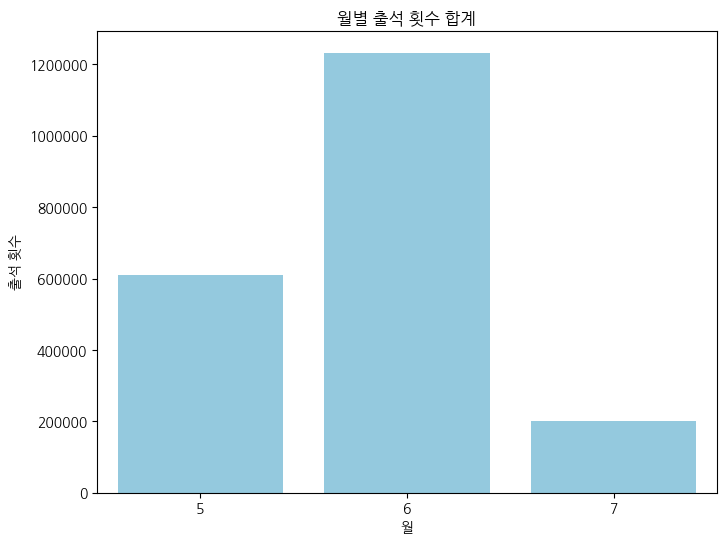

In [14]:
# 월별 누적 출석 횟수 시각화화
plt.figure(figsize=(8, 6))
sns.barplot(x='월', y='출석횟수', data=monthly_attendance, color='skyblue')
plt.xlabel('월')
plt.ylabel('출석 횟수')
plt.title('월별 출석 횟수 합계')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

,월,출석횟수,전체출석횟수,출석률
0,5,611238,2044320,29.899331
1,6,1232776,2044320,60.302497
2,7,200306,2044320,9.798172


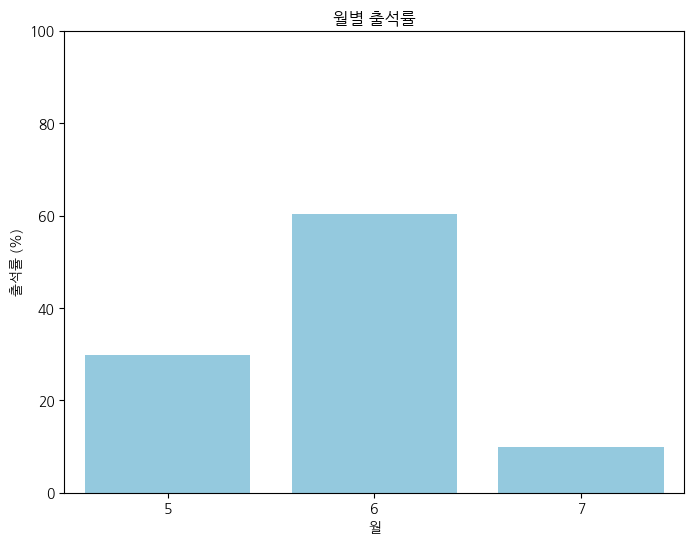

In [15]:
# 월별 누적 출석률 시각화

# 월별 사용자 수 집계
monthly_attendance['전체출석횟수'] = monthly_attendance['출석횟수'].sum()
monthly_attendance['출석률'] = (monthly_attendance['출석횟수'] / monthly_attendance['전체출석횟수']) * 100
display(monthly_attendance)

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x='월', y='출석률', data=monthly_attendance, color='skyblue')
plt.xlabel('월')
plt.ylabel('출석률 (%)')
plt.title('월별 출석률')
plt.ylim(0, 100)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [16]:
# 주차 계산
attendance_filtered['week'] =attendance_filtered['attendance_date_list'].dt.isocalendar().week
attendance_filtered

,id,attendance_date_list,user_id,attendance_count,month,year,week
0,1,2023-05-27,1446852,13,5,2023,21
0,1,2023-05-28,1446852,13,5,2023,21
0,1,2023-05-29,1446852,13,5,2023,22
0,1,2023-05-30,1446852,13,5,2023,22
0,1,2023-06-03,1446852,13,6,2023,22
...,...,...,...,...,...,...,...
339377,350175,2023-07-31,1390952,2,7,2023,31
339378,350176,2023-07-31,1537582,1,7,2023,31
339379,350177,2023-07-31,1345721,1,7,2023,31
339380,350178,2023-07-31,1307547,1,7,2023,31


In [17]:
wau_df = (
    attendance_filtered
    .groupby(['week'])['user_id']
    .nunique()
    .reset_index(name='WAU')
)
wau_df

,week,WAU
0,21,130312
1,22,273432
2,23,148277
3,24,76798
4,25,60000
5,26,32390
6,27,21902
7,28,26215
8,29,22174
9,30,19015


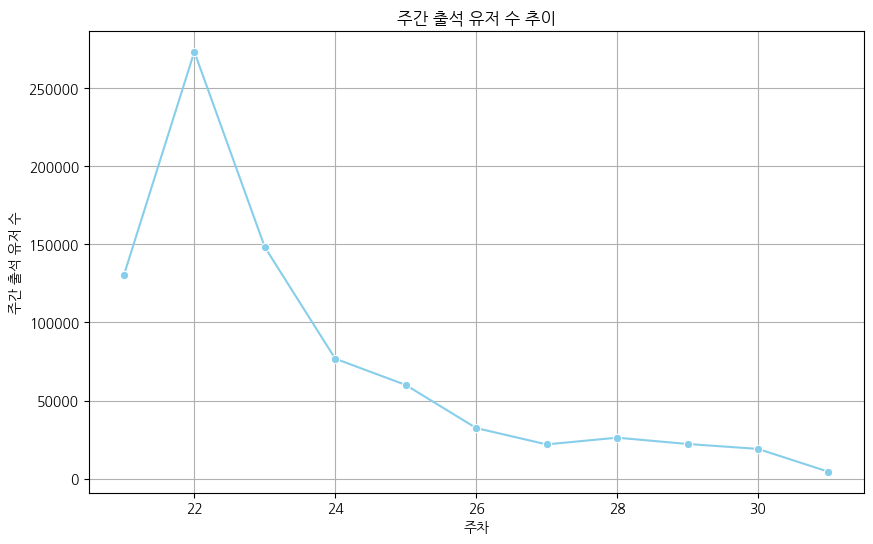

In [18]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=wau_df, x='week', y='WAU', marker='o', color='skyblue')
plt.xlabel('주차')
plt.ylabel('주간 출석 유저 수')
plt.title('주간 출석 유저 수 추이')
plt.grid(True)
plt.show()

In [19]:
daily_attendance = (
    attendance_filtered
    .groupby('attendance_date_list')['user_id']
    .nunique()
    .reset_index(name='daily_active_users')
)

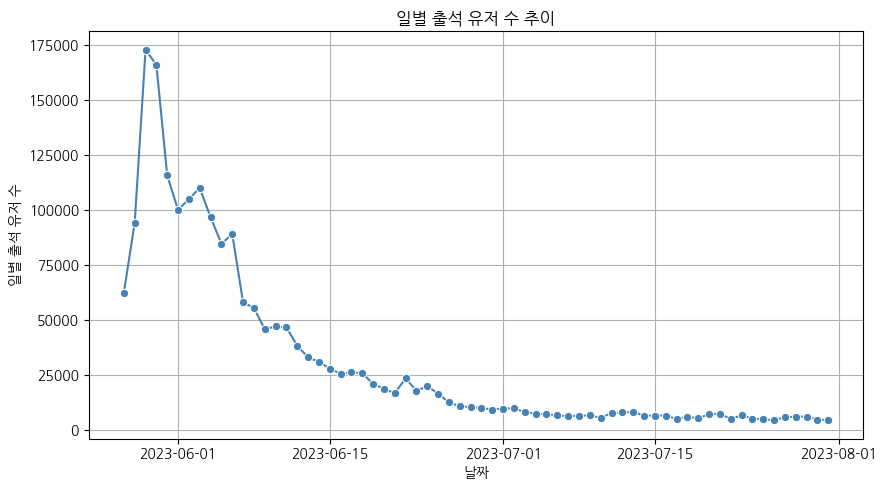

In [20]:
# 일별 출석 유저 수수
plt.figure(figsize=(9, 5))
sns.lineplot(
    data=daily_attendance,
    x='attendance_date_list',
    y='daily_active_users',
    marker='o',
    color='steelblue'
)
plt.xlabel('날짜')
plt.ylabel('일별 출석 유저 수')
plt.title('일별 출석 유저 수 추이')
plt.grid(True)
plt.tight_layout()
plt.show()

attendance에서는 뽑을 투표 하위 지표가 존재하지 않을 것으로 보임

##### 좀 더 알아보고 싶은 것
    - 출석에서 []인 경우의 유저들이 정말 활동 기록이 없는 것인가
        - 다른 votes 테이블들과 결합하여 알아보는 것 필요
        - 5월,6월 hackle에서는 click_attendance 존재하지 않음(click_attendacne는 7,8월에만 존재)
    => 그러면 빈 칸은 어떻게 판단??
    => 7월달 []과 hackle 교차 검증 필요?(추후 hackle 합의)

## 2. accounts_blockboard(차단 기록) 

In [21]:
blob = bucket.blob('votes/accounts_blockrecord.parquet')
parquet_bytes = blob.download_as_bytes()
blockrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
blockrecord.head()

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177


In [22]:
blockrecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19482 non-null  int64         
 1   reason         19482 non-null  object        
 2   created_at     19482 non-null  datetime64[ns]
 3   block_user_id  19482 non-null  int64         
 4   user_id        19482 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 761.1+ KB


In [23]:
blockrecord_df = blockrecord.copy()

# 사용 데이터 기간 5,6,7월
blockrecord_df = blockrecord[
    (blockrecord['created_at'].dt.year == 2023) &
    (blockrecord['created_at'].dt.month.isin([5, 6, 7]))
]
blockrecord_df

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177
...,...,...,...,...,...
19109,24633,친구 사이가 어색해짐,2023-07-31 05:58:03,1575252,1189694
19110,24634,친구 사이가 어색해짐,2023-07-31 07:33:15,1366472,1290241
19111,24635,사칭 계정,2023-07-31 10:30:39,1538473,1147008
19112,24636,친구 사이가 어색해짐,2023-07-31 15:18:11,1120482,1169555


In [24]:
# reason, block_user_id, user_id, created_at(날짜와 시와 분이이 동일한 경우) 중복으로 봄

blockrecord_time = blockrecord_df.copy()

# 분 단위로 반올림 (초 제거)
blockrecord_time['created_at_minute'] = blockrecord_time['created_at'].dt.floor('T')

# 중복 체크 -> 중복 존재
blockrecord_time[
    blockrecord_time.duplicated(subset=['reason', 'block_user_id', 'user_id', 'created_at_minute'], keep=False)
]

# 가장 최근 created_at 차단 기록을 남김
blockrecord_duplicated = blockrecord_time.sort_values(
    by=['reason', 'block_user_id', 'user_id', 'created_at_minute', 'created_at'],
    ascending=[True, True, True, True, False]
)
blockrecord_duplicated = blockrecord_duplicated.drop_duplicates(
    subset=['reason', 'block_user_id', 'user_id', 'created_at_minute'],
    keep='first'
)
blockrecord_duplicated

,id,reason,created_at,block_user_id,user_id,created_at_minute
0,1,그냥...,2023-05-04 23:01:53,867483,878476,2023-05-04 23:01:00
4,7,그냥...,2023-05-05 06:40:34,871349,870177,2023-05-05 06:40:00
18,27,그냥...,2023-05-05 16:03:55,874270,856647,2023-05-05 16:03:00
3,6,그냥...,2023-05-05 05:21:52,883696,883511,2023-05-05 05:21:00
10,14,그냥...,2023-05-05 13:04:52,885794,879662,2023-05-05 13:04:00
...,...,...,...,...,...,...
18834,24289,친구 사이가 어색해짐,2023-07-12 11:17:39,1578220,1578126,2023-07-12 11:17:00
18990,24493,친구 사이가 어색해짐,2023-07-23 11:28:45,1578324,1189660,2023-07-23 11:28:00
18897,24369,친구 사이가 어색해짐,2023-07-16 15:01:38,1578514,1518195,2023-07-16 15:01:00
19017,24529,친구 사이가 어색해짐,2023-07-24 12:12:05,1578625,886025,2023-07-24 12:12:00


In [25]:
blockrecord_time = blockrecord_df.copy()

# created_at에서 초 이하 제거(분 단위로 설정)
blockrecord_time['created_at_minute'] = blockrecord_time['created_at'].dt.floor('min')

# 날짜, 시, 분까지 동일한 경우 중복체크 후 가장 최근 created_at만 남기기
blockrecord_sorted = blockrecord_time.sort_values(by=['reason', 'block_user_id', 'user_id', 'created_at_minute', 'created_at'], 
                                                  ascending=[True, True, True, True, False])

blockrecord_duplicated = blockrecord_sorted.drop_duplicates(
    subset=['reason', 'block_user_id', 'user_id', 'created_at_minute'],
    keep='first'
).reset_index(drop=True)

blockrecord_duplicated

,id,reason,created_at,block_user_id,user_id,created_at_minute
0,1,그냥...,2023-05-04 23:01:53,867483,878476,2023-05-04 23:01:00
1,7,그냥...,2023-05-05 06:40:34,871349,870177,2023-05-05 06:40:00
2,27,그냥...,2023-05-05 16:03:55,874270,856647,2023-05-05 16:03:00
3,6,그냥...,2023-05-05 05:21:52,883696,883511,2023-05-05 05:21:00
4,14,그냥...,2023-05-05 13:04:52,885794,879662,2023-05-05 13:04:00
...,...,...,...,...,...,...
18869,24289,친구 사이가 어색해짐,2023-07-12 11:17:39,1578220,1578126,2023-07-12 11:17:00
18870,24493,친구 사이가 어색해짐,2023-07-23 11:28:45,1578324,1189660,2023-07-23 11:28:00
18871,24369,친구 사이가 어색해짐,2023-07-16 15:01:38,1578514,1518195,2023-07-16 15:01:00
18872,24529,친구 사이가 어색해짐,2023-07-24 12:12:05,1578625,886025,2023-07-24 12:12:00


In [26]:
print("차단 경험 있는 유니크 유저 수:", blockrecord_duplicated['user_id'].nunique())
print("차단 당한 경험 있는 유니크 유저 수:",blockrecord_duplicated['block_user_id'].nunique())

차단 경험 있는 유니크 유저 수: 12365
차단 당한 경험 있는 유니크 유저 수: 15924


In [27]:
# 차단 당한 유저의 차단 당한 횟수(최대 68회)
blockrecord_duplicated['block_user_id'].value_counts().reset_index()

,block_user_id,count
0,898020,74
1,897681,25
2,1380465,25
3,1395312,24
4,877266,24
...,...,...
15919,1216259,1
15920,1216278,1
15921,1216303,1
15922,1216359,1


In [28]:
# 한 유저가 차단한 횟수 -> 최대 171번 차단함 -> 그렇다면 어떤 유저를 차단한거지? 
# 한 유저만 여러 번?, 여러 유저들 여러 번?
blockrecord_duplicated['user_id'].value_counts().reset_index()

,user_id,count
0,1526194,171
1,1415197,163
2,1519819,70
3,1542675,66
4,986459,60
...,...,...
12360,1016102,1
12361,1223788,1
12362,1172515,1
12363,1267836,1


In [29]:
# 여러 명을 차단한 유저 추출
blockrecord_user_id_duplicated = blockrecord_duplicated[blockrecord_duplicated.duplicated('user_id', keep = False)]
blockrecord_user_id_duplicated = blockrecord_user_id_duplicated.sort_values(by = 'user_id')
print(blockrecord_user_id_duplicated['user_id'].nunique())
blockrecord_user_id_duplicated

2616


,id,reason,created_at,block_user_id,user_id,created_at_minute
6371,16470,모르는 사람임,2023-05-26 11:18:42,1158705,837786,2023-05-26 11:18:00
15727,18034,친구 사이가 어색해짐,2023-05-27 12:45:44,1108926,837786,2023-05-27 12:45:00
13302,189,친구 사이가 어색해짐,2023-05-06 12:17:10,840138,839967,2023-05-06 12:17:00
13301,188,친구 사이가 어색해짐,2023-05-06 12:16:49,839979,839967,2023-05-06 12:16:00
1641,9253,너무 많은 양의 질문을 보냄,2023-05-17 10:38:50,1262866,840429,2023-05-17 10:38:00
...,...,...,...,...,...,...
8431,24377,모르는 사람임,2023-07-16 23:15:46,1325128,1578854,2023-07-16 23:15:00
11163,24380,모르는 사람임,2023-07-16 23:15:58,1553086,1578854,2023-07-16 23:15:00
10933,24379,모르는 사람임,2023-07-16 23:15:54,1524837,1578854,2023-07-16 23:15:00
11265,24381,모르는 사람임,2023-07-16 23:16:04,1568079,1578854,2023-07-16 23:16:00


In [30]:
# user_id별 block_user_id별 차단 횟수 구하기
block_counts = blockrecord_user_id_duplicated.groupby(['user_id', 'block_user_id']).size().reset_index(name='block_count')
block_counts.sort_values(by = 'block_count')
block_counts

,user_id,block_user_id,block_count
0,837786,1108926,1
1,837786,1158705,1
2,839967,839979,1
3,839967,840138,1
4,840429,840550,1
...,...,...,...
8396,1578854,1325128,1
8397,1578854,1417756,1
8398,1578854,1524837,1
8399,1578854,1553086,1


In [31]:
# 한 명의 유저가 한 유저를 6회 이상 
block_counts[block_counts['block_count'] > 5]

,user_id,block_user_id,block_count
91,857420,898020,9
173,874687,874579,7
236,883198,907721,6
283,888946,909571,7
288,889732,876207,17
396,896862,898020,13
608,909818,898020,15
678,914610,920639,6
778,919367,901697,6
1154,941582,898020,7


In [32]:
# 여러 명에게 차단 당한 유저
blockrecord_blockuser_id_duplicated = blockrecord_duplicated[blockrecord_duplicated.duplicated('block_user_id', keep = False)]
blockrecord_blockuser_id_duplicated = blockrecord_blockuser_id_duplicated.sort_values(by = 'block_user_id')
print(blockrecord_blockuser_id_duplicated['block_user_id'].nunique())
blockrecord_blockuser_id_duplicated

1584


,id,reason,created_at,block_user_id,user_id,created_at_minute
1972,1461,모르는 사람임,2023-05-08 05:30:40,839623,846548,2023-05-08 05:30:00
1973,2208,모르는 사람임,2023-05-09 02:14:09,839623,853587,2023-05-09 02:14:00
1974,24273,모르는 사람임,2023-07-11 13:54:09,839794,848657,2023-07-11 13:54:00
1975,24632,모르는 사람임,2023-07-30 17:16:14,839794,848657,2023-07-30 17:16:00
1979,13587,모르는 사람임,2023-05-23 22:45:45,840550,1478154,2023-05-23 22:45:00
...,...,...,...,...,...,...
11318,23481,모르는 사람임,2023-06-14 22:56:50,1575252,1556992,2023-06-14 22:56:00
1062,23451,나랑 관련 없는 질문을 자꾸 보냄,2023-06-14 12:15:40,1575252,1560213,2023-06-14 12:15:00
18862,23530,친구 사이가 어색해짐,2023-06-15 16:38:26,1575252,1571954,2023-06-15 16:38:00
13294,23584,사칭 계정,2023-06-17 00:22:14,1575826,934025,2023-06-17 00:22:00


In [33]:
# block_user_id별 차단 당한 횟수 구하기
blockuser_counts = blockrecord_blockuser_id_duplicated.groupby(['block_user_id','user_id']).size().reset_index(name='block_count')
blockuser_counts.sort_values(by = 'block_count')
blockuser_counts

,block_user_id,user_id,block_count
0,839623,846548,1
1,839623,853587,1
2,839794,848657,2
3,840550,840429,1
4,840550,840542,1
...,...,...,...
3805,1575252,1571954,1
3806,1575252,1572381,1
3807,1575252,1572411,1
3808,1575826,934025,1


In [34]:
# block_user_id별 차단 당한 총 횟수 구하기
blockuser_total_counts = blockrecord_blockuser_id_duplicated.groupby(['block_user_id']).size().reset_index(name='block_count')
blockuser_total_counts.sort_values(by = 'block_count', ascending = False)

,block_user_id,block_count
119,898020,74
1330,1380465,25
117,897681,25
59,877266,24
1348,1395312,24
...,...,...
672,1090725,2
669,1090400,2
668,1090302,2
667,1090020,2


In [35]:
# 대체로 한 번 차단당한 경우가 대부분이며 한 유저에게 최대 15회까지 차단당함
blockuser_counts['block_count'].value_counts()

block_count
1     3375
2      293
3       81
4       29
5       15
6        8
7        4
9        2
17       1
13       1
15       1
Name: count, dtype: int64

##### 전처리
-  reason, block_user_id, user_id가 모두 중복이면?? ->  중복으로 볼 것인가(created_at 차이가 분과 초 정도일 경우)
- 차단 기록에 대해서 알아보는 것은 여기까지 진행하고, 투표관련 하위 지표를 발견하기 위한 고민이 필요함

## 3. accounts_failpaymenthistory(상품 구매 실패 기록)

In [36]:
blob = bucket.blob('votes/accounts_failpaymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
failpaymenthistory = pd.read_parquet(io.BytesIO(parquet_bytes))
failpaymenthistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730


In [37]:
failpaymenthistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          163 non-null    int64         
 1   productId   56 non-null     object        
 2   phone_type  163 non-null    object        
 3   created_at  163 non-null    datetime64[ns]
 4   user_id     163 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 6.5+ KB


In [38]:
# 사용 데이터 기간 5,6,7월
failpaymenthistory_df = failpaymenthistory.copy()

# 사용 데이터 기간 5,6,7월
failpaymenthistory_df = failpaymenthistory[
    (failpaymenthistory['created_at'].dt.year == 2023) &
    (failpaymenthistory['created_at'].dt.month.isin([5, 6, 7]))
]
failpaymenthistory_df

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730
...,...,...,...,...,...
154,166,None,I,2023-06-25 11:37:53,897014
155,167,None,I,2023-07-04 13:42:28,1575434
156,168,None,I,2023-07-12 12:14:11,925534
157,169,heart.777,A,2023-07-18 10:17:49,986403


- 5,6,7의 상품 구매 기록을 보니 159행, 기존 행은 163행 -> 정말 서비스가 7월 이후는 셧다운인가보다
- 상품 구매 실패 기록은 서비스 이용 유저 수에 비해 데이터가 적기 때문에 투표 관련해서는 영향이 거의 없지 않을까 추측해봄

## 4. accounts_friendrequest(친구요청)

In [3]:
blob = bucket.blob('votes/accounts_friendrequest.parquet')
parquet_bytes = blob.download_as_bytes()
friendrequest = pd.read_parquet(io.BytesIO(parquet_bytes))
friendrequest.head()

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


In [4]:
friendrequest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17147175 entries, 0 to 17147174
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   status           object        
 2   created_at       datetime64[ns]
 3   updated_at       datetime64[ns]
 4   receive_user_id  int64         
 5   send_user_id     int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 784.9+ MB


In [5]:
friendrequest_df = friendrequest.copy()

# 사용 데이터 기간 5,6,7월
friendrequest_df = friendrequest[
    (friendrequest['created_at'].dt.year == 2023) &
    (friendrequest['created_at'].dt.month.isin([5, 6, 7]))
]
friendrequest_df

,id,status,created_at,updated_at,receive_user_id,send_user_id
287213,370203,A,2023-05-01 00:00:02,2023-05-01 04:02:23,855424,862506
287214,370204,A,2023-05-01 00:00:06,2023-05-07 08:40:52,846127,853077
287215,370205,A,2023-05-01 00:00:06,2023-05-01 11:15:28,857441,862516
287216,370206,A,2023-05-01 00:00:06,2023-05-01 01:04:22,861993,862516
287217,370207,A,2023-05-01 00:00:06,2023-05-01 07:45:47,862510,862516
...,...,...,...,...,...,...
17061206,19600792,P,2023-07-31 21:53:23,2023-07-31 21:53:23,1241028,1261414
17061207,19600794,A,2023-07-31 22:37:49,2023-08-01 03:03:38,1300597,1207740
17061208,19600795,P,2023-07-31 22:48:32,2023-07-31 22:48:32,900525,892829
17061209,19600796,A,2023-07-31 23:18:43,2023-08-19 01:49:44,1579552,1233407


In [6]:
# status 상태
friendrequest_df['status'].value_counts()

status
A    12634740
P     3815788
R      323470
Name: count, dtype: int64

In [7]:
# created_at이 완전히 동일한 경우 중복체크
friendrequest_df = friendrequest_df.sort_values(by=['send_user_id', 'receive_user_id', 'status', 'created_at'], 
                                                  ascending=[True, True, True, True]).copy()
friendrequest_df

friendrequest_dup = friendrequest_df[friendrequest_df.duplicated(
    subset=['send_user_id', 'receive_user_id', 'created_at','status'],
    keep=False
)]
friendrequest_dup

,id,status,created_at,updated_at,receive_user_id,send_user_id
3278566,3804529,A,2023-05-09 08:52:43,2023-05-09 10:13:33,968711,968648
3278567,3804530,A,2023-05-09 08:52:43,2023-05-10 13:58:39,968711,968648
2366996,2774524,A,2023-05-08 04:38:36,2023-05-08 07:15:47,892254,990693
2367024,2774553,A,2023-05-08 04:38:36,2023-05-08 07:15:50,892254,990693
2366997,2774525,A,2023-05-08 04:38:36,2023-05-08 08:00:44,895626,990693
...,...,...,...,...,...,...
14619506,16830736,A,2023-05-25 22:53:33,2023-05-31 07:50:59,1491114,1512824
14619486,16830715,A,2023-05-25 22:53:33,2023-05-27 09:23:20,1508756,1512824
14619507,16830737,A,2023-05-25 22:53:33,2023-06-01 14:42:50,1508756,1512824
15587356,17937595,A,2023-05-28 15:50:22,2023-05-28 16:07:01,1511973,1539720


In [8]:
# 중복 친구 신청 내역 중 accept(수락)가 가장 많음
friendrequest_dup['status'].value_counts()

status
A    160
P     48
R      2
Name: count, dtype: int64

In [9]:
# 중복 제거
# 'created_at'이 동일한 경우 중복체크 후 가장 최근 'updated_at'만 남기기
friendrequest_df = friendrequest_df.sort_values(
    by=['send_user_id', 'receive_user_id', 'status', 'created_at', 'updated_at'],
    ascending=[True, True, True, True, False]
).copy()

friendrequest_df = friendrequest_df.drop_duplicates(
    subset=['send_user_id', 'receive_user_id', 'status', 'created_at'],
    keep='first'
).reset_index(drop=True)

friendrequest_df

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,19552415,A,2023-07-13 07:51:59,2023-09-11 15:38:43,1446852,831962
1,4382181,P,2023-05-09 15:50:58,2023-05-09 15:50:58,882567,832151
2,5549256,P,2023-05-11 00:51:26,2023-05-11 00:51:26,874212,832340
3,13449651,A,2023-05-20 16:48:38,2023-05-23 10:39:10,1308881,833024
4,17660117,P,2023-05-28 02:44:12,2023-05-28 02:44:12,1354259,833024
...,...,...,...,...,...,...
16773888,19600784,A,2023-07-31 21:05:08,2023-08-01 01:48:34,1263898,1579644
16773889,19600785,P,2023-07-31 21:05:08,2023-07-31 21:05:08,1330113,1579644
16773890,19600786,P,2023-07-31 21:05:08,2023-07-31 21:05:08,1339578,1579644
16773891,19600787,P,2023-07-31 21:05:08,2023-07-31 21:05:08,1386984,1579644


In [10]:
friendrequest_df['status'].value_counts()

status
A    12634660
P     3815764
R      323469
Name: count, dtype: int64

In [11]:
# 친구 요청 상태 status가 A(수락)인 유저들의 투표율
send_user_id_a = friendrequest_df[friendrequest_df['status'] == 'A']
send_user_id_a

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,19552415,A,2023-07-13 07:51:59,2023-09-11 15:38:43,1446852,831962
3,13449651,A,2023-05-20 16:48:38,2023-05-23 10:39:10,1308881,833024
8,1247667,A,2023-05-06 12:08:13,2023-05-07 06:14:29,864030,833041
11,9893537,A,2023-05-15 12:08:35,2023-06-07 06:45:28,1118793,833041
16,17677004,A,2023-05-28 03:55:12,2023-09-11 15:38:41,1446852,833041
...,...,...,...,...,...,...
16773779,19600648,A,2023-07-31 16:55:04,2023-07-31 16:58:42,1305865,1579642
16773783,19600644,A,2023-07-31 16:52:37,2023-08-04 11:02:01,1377420,1579642
16773791,19600693,A,2023-07-31 21:05:08,2023-08-20 12:16:41,917756,1579644
16773885,19600782,A,2023-07-31 21:05:08,2023-08-23 14:32:42,1190085,1579644


In [12]:
# 친구 요청 수락 많이 받은 유저
send_user_count = send_user_id_a.groupby('send_user_id').size().reset_index(name = 'send_user_count')
send_user_count.sort_values(by = 'send_user_count', ascending = False)

,send_user_id,send_user_count
14843,868174,654
591447,1533716,626
437508,1353849,570
308200,1203441,521
298612,1192441,501
...,...,...
600110,1543423,1
455819,1375748,1
134956,1006172,1
316277,1212745,1


In [13]:
# 친구 요청 수락 받은 유저들의 투표 횟수


- 친구 요청 후 친구 받아준 유저(status = A) 중에서 투표에 잠여한 receive_user_id

## 5. accounts_group(학급 테이블)

In [21]:
blob = bucket.blob('votes/accounts_group.parquet')
parquet_bytes = blob.download_as_bytes()
group = pd.read_parquet(io.BytesIO(parquet_bytes))
group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [ ]:
group.info()

In [ ]:
group.describe()

In [ ]:
group['grade'].value_counts()

In [ ]:
group['class_num'].value_counts()

In [ ]:
# grade와 class_num 이상치 제거
# group_df = group.copy()

group_df = group[(~group['grade'].isin([4,20])) & (~group['class_num'].isin([0,41]))]
group_df

In [ ]:
print(group_df['grade'].value_counts())
print(group_df['class_num'].value_counts())

In [ ]:
group_df['school_id'].nunique()

In [ ]:
# 학교별 -> 학년별 -> 반 학생 수 -> 각 학교 서비스 가입 전체 학생 수
# 반별 학생 수
group_counts = group_df.groupby(['school_id', 'grade', 'class_num']).size().reset_index(name='user_counts')

# 학교별 전체 학생 수
school_counts = group_df.groupby('school_id').size().reset_index(name='school_total_user_count')

# 병합
group_counts = group_counts.merge(school_counts, on='school_id', how='left')

group_counts

In [ ]:
group_counts[group_counts['school_id']==1]

In [ ]:
group_counts[group_counts['user_counts']>1]

In [ ]:
group_counts.info()

In [ ]:
group_counts.sort_values(by = 'school_total_user_count', ascending = False)

In [ ]:
# 각 학교별 총 이용자 수
school_user_counts = group_counts.groupby('school_id')['school_total_user_count'].first().reset_index()
school_user_counts = school_user_counts.sort_values(by = 'school_total_user_count', ascending = False)
school_user_counts

## 6. accounts_nearbyschool(가까운 학교 기록해주는 관계형 테이블)

In [22]:
blob = bucket.blob('votes/accounts_nearbyschool.parquet')
parquet_bytes = blob.download_as_bytes()
nearbyschool = pd.read_parquet(io.BytesIO(parquet_bytes))
nearbyschool.head()

,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7


## 7. accounts_paymenthistory(구매 기록)

In [ ]:
blob = bucket.blob('votes/accounts_paymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
paymetnhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
paymetnhistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081


In [36]:
paymetnhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95140 entries, 0 to 95139
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          95140 non-null  int64         
 1   productId   95140 non-null  object        
 2   phone_type  95140 non-null  object        
 3   created_at  95140 non-null  datetime64[ns]
 4   user_id     95140 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.6+ MB


In [37]:
paymetnhistory_df = paymetnhistory.copy()

# 사용 데이터 기간 5,6,7월
paymetnhistory_df = paymetnhistory[
    (paymetnhistory['created_at'].dt.year == 2023) &
    (paymetnhistory['created_at'].dt.month.isin([5, 6, 7]))
]
paymetnhistory_df

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081
...,...,...,...,...,...
92119,95040,heart.200,I,2023-07-31 19:28:16,1322228
92120,95041,heart.777,I,2023-07-31 19:40:25,1110543
92121,95042,heart.777,I,2023-07-31 20:01:35,1334617
92122,95043,heart.777,A,2023-07-31 20:06:55,1342405


## 8. accounts_user_contacts(유저 컨택)

In [24]:
blob = bucket.blob('votes/accounts_user_contacts.parquet')
parquet_bytes = blob.download_as_bytes()
user_contacts = pd.read_parquet(io.BytesIO(parquet_bytes))
user_contacts.head()

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476


In [ ]:
# 전화번호를 가지고 있는 유저 수가 가정 많은 경우 => 114건
user_contacts['contacts_count'].max()

114

## 9. accounts_pointhisotry(포인트 기록 테이블)
- delta_point(포인트 양)
- user_question_record_id(투표 기록 id)

In [ ]:
blob = bucket.blob('votes/accounts_pointhistory.parquet')
parquet_bytes = blob.download_as_bytes()
pointhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
pointhistory.head()

,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0


In [39]:
pointhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[ns]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 89.2 MB


In [40]:
pointhistory_df = pointhistory.copy()

# 사용 데이터 기간 5,6,7월
pointhistory_df = pointhistory[
    (pointhistory['created_at'].dt.year == 2023) &
    (pointhistory['created_at'].dt.month.isin([5, 6, 7]))
]
pointhistory_df

,id,delta_point,created_at,user_id,user_question_record_id
31727,1523193,5,2023-05-01 03:37:42,857913,1481996.0
31728,1523404,8,2023-05-01 03:38:24,856430,1482200.0
31729,1523478,8,2023-05-01 03:38:38,856430,1482273.0
31730,1523527,7,2023-05-01 03:38:48,856430,1482321.0
31731,1523553,11,2023-05-01 03:38:53,856430,1482347.0
...,...,...,...,...,...
2326983,337419974,300,2023-07-31 17:53:26,849103,NaN
2326984,337420447,230,2023-07-31 18:05:02,865130,NaN
2326985,337420458,-500,2023-07-31 18:05:46,865130,2137872.0
2326986,337420485,-1000,2023-07-31 18:06:18,865130,3110206.0


## 10. accounts_school(학교)

In [41]:
blob = bucket.blob('votes/accounts_school.parquet')
parquet_bytes = blob.download_as_bytes()
school = pd.read_parquet(io.BytesIO(parquet_bytes))
school.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


## 11. accounts_timelinereport(유저 신고 기록)
- user_question_record_id : 투표기록 id
- reported_user_id : 신고 대상 유저 id

In [27]:
blob = bucket.blob('votes/accounts_timelinereport.parquet')
parquet_bytes = blob.download_as_bytes()
timelineReport = pd.read_parquet(io.BytesIO(parquet_bytes))
timelineReport.head()

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049


In [28]:
timelineReport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       208 non-null    int64         
 1   reason                   208 non-null    object        
 2   created_at               208 non-null    datetime64[ns]
 3   reported_user_id         208 non-null    int64         
 4   user_id                  208 non-null    int64         
 5   user_question_record_id  208 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 9.9+ KB


In [29]:
timelineReport_df = timelineReport.copy()

# 사용 데이터 기간 5,6,7월
timelineReport_df = timelineReport[
    (timelineReport['created_at'].dt.year == 2023) &
    (timelineReport['created_at'].dt.month.isin([5, 6, 7]))
]
timelineReport_df

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049
...,...,...,...,...,...,...
203,21857,선정적이거나 폭력적인 내용,2023-05-29 15:42:50,1479859,1402487,131364422
204,22634,허위 사실 언급,2023-05-31 10:33:00,1551005,1161757,135982670
205,22635,허위 사실 언급,2023-05-31 10:33:06,1551005,1161757,134909577
206,23022,선정적이거나 폭력적인 내용,2023-06-01 16:02:33,1479859,1498172,139837310


In [31]:
timelineReport_df['reason'].value_counts().reset_index()

,reason,count
0,허위 사실 언급,80
1,친구를 비하하거나 조롱하는 어투,64
2,선정적이거나 폭력적인 내용,39
3,타인을 사칭함,15
4,광고,10


## 12. accounts_user(유저)
- is_superuser : superuser 여부
- is_staff : staff 여부
- firebase_id : 과거 firebase 세션 관리 할 때 사용하는 식별자(이 컬럼은 제거 예정)
- friend_id_list : 친구 id 데이터
- block_user_id_list : 차단한 유저 id 데이터
- hide_user_id_list : 숨김 처리한 유저 id 데이터
- ban_status : 차단 혹은 탈퇴한 유저인지 타입
- report_count : 신고 당한 횟수
- alarm_count : 알람 갯수
- pending_chat: 안읽은 채팅 개수
- pending_votes : 확인 안한 투표 개수

In [45]:
blob = bucket.blob('votes/accounts_user.parquet')
parquet_bytes = blob.download_as_bytes()
user = pd.read_parquet(io.BytesIO(parquet_bytes))
user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [46]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  677085 non-null  int64         
 1   is_superuser        677085 non-null  int64         
 2   is_staff            677085 non-null  int64         
 3   gender              677083 non-null  object        
 4   point               677085 non-null  int64         
 5   friend_id_list      677085 non-null  object        
 6   is_push_on          677085 non-null  int64         
 7   created_at          677085 non-null  datetime64[ns]
 8   block_user_id_list  677085 non-null  object        
 9   hide_user_id_list   677085 non-null  object        
 10  ban_status          677085 non-null  object        
 11  report_count        677085 non-null  int64         
 12  alarm_count         677085 non-null  int64         
 13  pending_chat        677085 no

In [47]:
user_df = user.copy()

# 사용 데이터 기간 5,6,7월
user_df = user[
    (user['created_at'].dt.year == 2023) &
    (user['created_at'].dt.month.isin([5, 6, 7]))
]
user_df

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
13302,855179,0,0,M,1358,"[849767, 850569, 857770, 856249, 850108, 869470]",1,2023-05-18 16:36:23.667542,[],[],N,0,1,0,23,5532.0
19094,862517,0,0,F,1391,"[880775, 838285, 868495, 875156, 838421, 83842...",1,2023-05-01 00:00:12.942200,[],[],N,0,1,0,19,6337.0
19095,862518,0,0,F,1063,"[857473, 846981, 860934, 858247, 859913, 86901...",1,2023-05-01 00:00:22.647793,[],[],N,0,0,0,61,7020.0
19096,862519,0,0,F,2137,"[1215494, 1150344, 1520776, 1160844, 1090445, ...",0,2023-05-01 00:00:32.161347,[],[],N,0,2,0,180,7392.0
19097,862520,0,0,M,2838,"[874368, 856706, 1407234, 982788, 1145859, 100...",1,2023-05-01 00:00:48.974195,[],[],N,0,1,0,190,3526.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673179,1579640,0,0,M,366,"[1519483, 1522180, 1535237, 1544166, 875815, 1...",1,2023-07-31 16:40:15.522415,[],[],N,0,1,0,0,81557.0
673180,1579641,0,0,M,519,"[1001084, 1160516, 1020645, 1013905, 1004146, ...",1,2023-07-31 16:48:48.598009,[],[],N,0,1,0,0,32088.0
673181,1579642,0,0,M,545,"[983683, 1001223, 1336712, 1330442, 1377420, 1...",0,2023-07-31 16:52:27.877076,[],[],N,0,1,0,0,10260.0
673182,1579643,0,0,F,311,[1503084],0,2023-07-31 17:48:00.152054,[],[],N,0,1,0,1,28720.0


## 13. accounts_userquestionrecord(투표기록)
- status : 상태(C : closed(닫힘), I : initial(초성 열림), B: blocked(차단))
- chosen_user_id : 선택 받은 유저 id
- opened_times : 열어본 횟수
- question_id : 질문 id
- question_piece_id : 투표 id
- answer_status : 답장 상태(N : 미답변, P : 비공개, A : 공개)
- answer_updated_at : 답장 시간
- report_count : 신고 횟수
- has_read : 읽었는지 여부

유령회원을 알아보자(기간을 나눠서 보자)

In [14]:
blob = bucket.blob('votes/accounts_userquestionrecord.parquet')
parquet_bytes = blob.download_as_bytes()
userquestionrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
userquestionrecord.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [15]:
userquestionrecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217558 entries, 0 to 1217557
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id                 1217558 non-null  int64         
 1   status             1217558 non-null  object        
 2   created_at         1217558 non-null  datetime64[ns]
 3   chosen_user_id     1217558 non-null  int64         
 4   question_id        1217558 non-null  int64         
 5   user_id            1217558 non-null  int64         
 6   question_piece_id  1217558 non-null  int64         
 7   has_read           1217558 non-null  int64         
 8   answer_status      1217558 non-null  object        
 9   answer_updated_at  1217558 non-null  datetime64[ns]
 10  report_count       1217558 non-null  int64         
 11  opened_times       1217558 non-null  int64         
dtypes: datetime64[ns](2), int64(8), object(2)
memory usage: 111.5+ MB


#### 13-1. 데이터 기한 설정

In [16]:
# 사용 데이터 기간 5,6,7월
userquestionrecord_df = userquestionrecord[
    (userquestionrecord['created_at'].dt.year == 2023) &
    (userquestionrecord['created_at'].dt.month.isin([5, 6, 7]))
]
userquestionrecord_df

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1212211,160262886,C,2023-07-31 16:06:08,859802,1653,866250,187023487,0,N,2023-07-31 16:06:08,0,0
1212212,160262893,C,2023-07-31 16:06:14,850774,1967,866250,187023488,0,N,2023-07-31 16:06:14,0,0
1212213,160262898,C,2023-07-31 16:06:19,1205810,2948,866250,187023489,0,N,2023-07-31 16:06:19,0,0
1212214,160262908,I,2023-07-31 16:06:28,865846,2253,866250,187023490,1,N,2023-07-31 16:06:28,0,2


In [17]:
userquestionrecord_df[userquestionrecord_df.duplicated(subset=['question_id','user_id',	'question_piece_id','chosen_user_id'] )]

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times


In [18]:
userquestionrecord_df[userquestionrecord_df.duplicated('user_id')]

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0
30803,1482358,C,2023-05-01 03:38:54,859641,115,857913,1821410,0,N,2023-05-01 03:38:54,0,0
30804,1482395,C,2023-05-01 03:39:02,850774,312,856430,1861803,0,N,2023-05-01 03:39:02,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1212211,160262886,C,2023-07-31 16:06:08,859802,1653,866250,187023487,0,N,2023-07-31 16:06:08,0,0
1212212,160262893,C,2023-07-31 16:06:14,850774,1967,866250,187023488,0,N,2023-07-31 16:06:14,0,0
1212213,160262898,C,2023-07-31 16:06:19,1205810,2948,866250,187023489,0,N,2023-07-31 16:06:19,0,0
1212214,160262908,I,2023-07-31 16:06:28,865846,2253,866250,187023490,1,N,2023-07-31 16:06:28,0,2


#### 13-2. 투표 열어본 적 없는 유저(opened_times = 0)

In [19]:
# 투표 열어본 적 없는 유저
userquestionrecord_open_no = userquestionrecord_df[userquestionrecord_df['opened_times'] == 0]
userquestionrecord_open_no

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1212210,160262880,C,2023-07-31 16:06:01,863160,1897,866250,187023486,1,N,2023-07-31 16:06:01,0,0
1212211,160262886,C,2023-07-31 16:06:08,859802,1653,866250,187023487,0,N,2023-07-31 16:06:08,0,0
1212212,160262893,C,2023-07-31 16:06:14,850774,1967,866250,187023488,0,N,2023-07-31 16:06:14,0,0
1212213,160262898,C,2023-07-31 16:06:19,1205810,2948,866250,187023489,0,N,2023-07-31 16:06:19,0,0


#### 13-3. 투표를 열어보지 않았는데 읽었다고 기록된 경우

In [20]:
# 투표 열어본 횟수(opened_times) = 0 / 읽었는지 여부(has_read) = 1 : 투표를 열어보지 않았는데 읽었다고 하는 경우
openno_hasread = userquestionrecord_open_no[userquestionrecord_open_no['has_read'] != 0]
openno_hasread

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30816,1482715,C,2023-05-01 03:40:02,856197,149,858265,1864700,1,N,2023-05-01 03:40:02,0,0
30817,1482743,C,2023-05-01 03:40:07,856197,168,858265,1864701,1,N,2023-05-01 03:40:07,0,0
30819,1482801,C,2023-05-01 03:40:19,859468,151,857913,1821417,1,N,2023-05-01 03:40:19,0,0
30820,1482802,C,2023-05-01 03:40:19,860392,253,858265,1864703,1,N,2023-05-01 03:40:19,0,0
30826,1482871,C,2023-05-01 03:40:36,859587,271,858467,1865279,1,N,2023-05-01 03:40:36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1212198,160262673,C,2023-07-31 16:00:21,876682,4950,875201,204410374,1,N,2023-07-31 16:00:21,0,0
1212207,160262831,C,2023-07-31 16:05:26,1465456,2705,866250,187023483,1,N,2023-07-31 16:05:26,0,0
1212208,160262850,C,2023-07-31 16:05:41,846995,2340,866250,187023484,1,N,2023-07-31 16:05:41,0,0
1212210,160262880,C,2023-07-31 16:06:01,863160,1897,866250,187023486,1,N,2023-07-31 16:06:01,0,0


In [21]:
# 투표 열어보지 않았는데, 읽어봤다라고 되어있는 경우 -> 상태 닫힘(C)인 경우가 많음
openno_hasread['status'].value_counts()

status
C    613544
B       232
Name: count, dtype: int64

In [22]:
openno_hasread[openno_hasread['user_id'].duplicated()]

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30817,1482743,C,2023-05-01 03:40:07,856197,168,858265,1864701,1,N,2023-05-01 03:40:07,0,0
30820,1482802,C,2023-05-01 03:40:19,860392,253,858265,1864703,1,N,2023-05-01 03:40:19,0,0
30827,1482885,C,2023-05-01 03:40:38,860392,208,858265,1864707,1,N,2023-05-01 03:40:38,0,0
30840,1483159,C,2023-05-01 03:41:39,857337,238,858467,1865286,1,N,2023-05-01 03:41:39,0,0
30888,1484342,C,2023-05-01 03:45:59,858807,202,858674,1838160,1,N,2023-05-01 03:45:59,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1212198,160262673,C,2023-07-31 16:00:21,876682,4950,875201,204410374,1,N,2023-07-31 16:00:21,0,0
1212207,160262831,C,2023-07-31 16:05:26,1465456,2705,866250,187023483,1,N,2023-07-31 16:05:26,0,0
1212208,160262850,C,2023-07-31 16:05:41,846995,2340,866250,187023484,1,N,2023-07-31 16:05:41,0,0
1212210,160262880,C,2023-07-31 16:06:01,863160,1897,866250,187023486,1,N,2023-07-31 16:06:01,0,0


In [23]:
# 상태가 차단인 상태태
status_b = openno_hasread[openno_hasread['status']=='B']
status_b

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
36164,1643686,B,2023-05-01 11:16:53,850847,254,850176,1820749,1,N,2023-05-01 11:16:53,0,0
36169,1643802,B,2023-05-01 11:17:08,852358,268,850176,1820751,1,N,2023-05-01 11:17:08,0,0
36178,1643929,B,2023-05-01 11:17:27,852358,196,850176,1820753,1,N,2023-05-01 11:17:27,0,0
36186,1644052,B,2023-05-01 11:17:43,850847,163,850176,1820755,1,N,2023-05-01 11:17:43,0,0
37166,1674993,B,2023-05-01 12:19:09,852358,325,850176,2150032,1,N,2023-05-01 12:19:09,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1141487,139709438,B,2023-06-01 15:08:09,855748,1149,865953,176346204,1,N,2023-06-01 15:08:09,0,0
1173080,148270644,B,2023-06-06 01:13:22,1159745,2547,914854,189750689,1,A,2023-06-06 12:40:30,0,0
1177982,149550371,B,2023-06-06 13:56:10,1407066,1007,1471148,174643000,1,N,2023-06-06 13:56:10,0,0
1184839,151466793,B,2023-06-08 12:59:52,876643,3718,877367,193808203,1,N,2023-06-08 12:59:52,0,0


In [24]:
# 차단인 상태 중 만든 시간과 답장 시간이 같은 경우
b = status_b[(status_b['created_at']) == (status_b['answer_updated_at'])]
b['answer_status'].value_counts()

answer_status
N    202
Name: count, dtype: int64

In [25]:
# 투표 열어본 횟수 1번 이상인 경우 추출
userquestionrecord_open_yes = userquestionrecord_df[userquestionrecord_df['opened_times'] >= 1]
userquestionrecord_open_yes

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30810,1482581,I,2023-05-01 03:39:37,855752,220,857913,1821414,0,N,2023-05-01 03:39:37,0,1
30823,1482846,I,2023-05-01 03:40:28,855713,257,858265,1864705,0,N,2023-05-01 03:40:28,0,1
30846,1483746,I,2023-05-01 03:43:46,861710,251,855825,1847561,0,N,2023-05-01 03:43:46,0,1
30847,1483848,I,2023-05-01 03:44:07,862659,161,855825,1847562,0,N,2023-05-01 03:44:07,0,1
30879,1484258,I,2023-05-01 03:45:38,850130,111,855817,1857645,1,N,2023-05-01 03:45:38,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1212126,160254527,I,2023-07-31 12:29:10,1165022,679,1169212,206170871,1,N,2023-07-31 12:29:10,0,1
1212145,160255721,I,2023-07-31 13:01:26,1111933,1449,1208878,206044242,1,N,2023-07-31 13:01:26,0,1
1212164,160260763,I,2023-07-31 15:12:54,874880,1217,875083,205837592,1,N,2023-07-31 15:12:54,0,1
1212170,160260796,I,2023-07-31 15:14:00,875201,396,875083,205837599,1,N,2023-07-31 15:14:00,0,3


In [26]:
# 투표 열어본 유저 유니크 수
userquestionrecord_open_yes['user_id'].nunique()

4518

In [27]:
# 유저들이 투표 열어본 횟수 value_counts
userquestionrecord_open_yes['opened_times'].value_counts()

opened_times
1    45603
2    11039
3     2622
Name: count, dtype: int64

In [28]:
# 투표 열어봄(opened_times) >= 1 /  읽었는지 여부(has_read) = 1 : 투표 열어보고 읽음
userquestionrecord_open_yes[userquestionrecord_open_yes['has_read'] == 1]

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30879,1484258,I,2023-05-01 03:45:38,850130,111,855817,1857645,1,N,2023-05-01 03:45:38,0,1
30908,1484539,I,2023-05-01 03:46:37,856042,132,858674,1838162,1,N,2023-05-01 03:46:37,0,1
30976,1485022,I,2023-05-01 03:48:44,857957,197,854615,1858405,1,N,2023-05-01 03:48:44,0,1
31001,1485261,I,2023-05-01 03:49:39,860153,313,855694,1800280,1,N,2023-05-01 03:49:39,0,1
31002,1485294,I,2023-05-01 03:49:46,860153,136,855694,1800281,1,N,2023-05-01 03:49:46,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1212126,160254527,I,2023-07-31 12:29:10,1165022,679,1169212,206170871,1,N,2023-07-31 12:29:10,0,1
1212145,160255721,I,2023-07-31 13:01:26,1111933,1449,1208878,206044242,1,N,2023-07-31 13:01:26,0,1
1212164,160260763,I,2023-07-31 15:12:54,874880,1217,875083,205837592,1,N,2023-07-31 15:12:54,0,1
1212170,160260796,I,2023-07-31 15:14:00,875201,396,875083,205837599,1,N,2023-07-31 15:14:00,0,3


In [29]:
# 투표 열어봄(opened_times) >= 1 /  읽었는지 여부(has_read) = 0 : 투표 열어보고 읽지 않음
userquestionrecord_open_yes[userquestionrecord_open_yes['has_read'] != 1]

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30810,1482581,I,2023-05-01 03:39:37,855752,220,857913,1821414,0,N,2023-05-01 03:39:37,0,1
30823,1482846,I,2023-05-01 03:40:28,855713,257,858265,1864705,0,N,2023-05-01 03:40:28,0,1
30846,1483746,I,2023-05-01 03:43:46,861710,251,855825,1847561,0,N,2023-05-01 03:43:46,0,1
30847,1483848,I,2023-05-01 03:44:07,862659,161,855825,1847562,0,N,2023-05-01 03:44:07,0,1
30989,1485139,I,2023-05-01 03:49:16,850601,276,856002,1863745,0,N,2023-05-01 03:49:16,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
183839,4710561,I,2023-05-06 13:26:08,886748,320,883122,6158949,0,N,2023-05-06 13:26:08,0,1
202333,5614596,I,2023-05-07 03:49:56,875434,547,885136,6436544,0,N,2023-05-07 03:49:56,0,1
207205,5872400,I,2023-05-07 05:42:43,875741,197,888202,4905421,0,N,2023-05-07 05:42:43,0,1
213518,6232620,I,2023-05-07 08:20:06,878246,192,873691,6821110,0,N,2023-05-07 08:20:06,0,1


투표 기록 관련 질문(6월 hackle 데이터 기준)
- "의문점" : 투표(opened_times) 열어본적 없는데(=0) 읽었는지 여부(has_read)가 1인 경우
1. 6월 12일 hackle 데이터의 event_key를 살펴봐야하나?(잘 모르겠음)
2. opend_times(열어본 횟수) => 투표를 열었다는 것은 UI에서 어떤 페이지에 있다는 걸까?
3. 예측을 해보면 : 투표를 열었다 => 10개의 질문이 나열되어있는 페이지로 진입 => 그러고 나서 질문을 클릭해야 읽었는지 여부가 변경?(hackle 확인 해야하나??)
4. 그런데 투표를 연적이 없는데 읽었다 => 바로 질문 페이지로 이동이 되는 걸까?(이것도 hackle 확인 필요)
5. 예측해 본 이벤트 순서     
    'click_question_start(홈 화면에서 질문 start 클릭)' -> 'view_questions_tap(질문화면 진입)' -> 'click_question_open(받은 질문을 열 때)'

### 6월 hackle 데이터 함께 살펴보기

In [ ]:
blob = bucket.blob('hackle/2023-06-17.parquet')
parquet_bytes = blob.download_as_bytes()
hackle_20230617 = pd.read_parquet(io.BytesIO(parquet_bytes))
hackle_20230617.head()

In [ ]:
hackle_20230617_df = hackle_20230617(columns = ['event_key', 'session_id', ])

In [ ]:
pd.set_option('display.max_columns', None) # 컬럼(열)
pd.set_option('display.max_rows', None) # 행

In [ ]:
hackle_20230617['event_key'].value_counts()

## 14. accounts_userwithdraw(탈퇴 기록)

In [52]:
blob = bucket.blob('votes/accounts_userwithdraw.parquet')
parquet_bytes = blob.download_as_bytes()
userwithdraw = pd.read_parquet(io.BytesIO(parquet_bytes))
userwithdraw.head()

,id,reason,created_at
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19


In [53]:
userwithdraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70764 entries, 0 to 70763
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          70764 non-null  int64         
 1   reason      70764 non-null  object        
 2   created_at  70764 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ MB


In [54]:
userwithdraw_df = userwithdraw.copy()

# 사용 데이터 기간 5,6,7월
userwithdraw_df = userwithdraw[
    (userwithdraw['created_at'].dt.year == 2023) &
    (userwithdraw['created_at'].dt.month.isin([5, 6, 7]))
]
userwithdraw_df

,id,reason,created_at
2414,2487,기타 이유,2023-05-01 00:27:23
2415,2488,재밌는 질문이 없어서,2023-05-01 00:28:24
2416,2489,기타 이유,2023-05-01 00:43:31
2417,2490,기타 이유,2023-05-01 00:44:45
2418,2491,기타 이유,2023-05-01 00:59:27
...,...,...,...
61707,61837,기타 이유,2023-07-31 18:54:09
61708,61838,기타 이유,2023-07-31 19:00:12
61709,61839,기타 이유,2023-07-31 19:04:24
61710,61840,기타 이유,2023-07-31 22:37:52


## 15. event_receipts(포인트 이벤트 참여)

In [34]:
blob = bucket.blob('votes/event_receipts.parquet')
parquet_bytes = blob.download_as_bytes()
receipts = pd.read_parquet(io.BytesIO(parquet_bytes))
receipts.head()

,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500


In [35]:
receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          309 non-null    int64         
 1   created_at  309 non-null    datetime64[ns]
 2   event_id    309 non-null    int64         
 3   user_id     309 non-null    int64         
 4   plus_point  309 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 12.2 KB


In [36]:
receipts_df = receipts.copy()

# 사용 데이터 기간 5,6,7월
receipts_df = receipts[
    (receipts['created_at'].dt.year == 2023) &
    (receipts['created_at'].dt.month.isin([5, 6, 7]))
]
receipts_df

,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500
...,...,...,...,...,...
247,255,2023-07-30 17:40:28,1,1129632,500
248,256,2023-07-30 19:56:36,1,1291851,500
249,257,2023-07-30 21:39:30,1,877152,500
250,258,2023-07-31 12:52:18,1,1299020,500


In [ ]:
# 5,6,7월의 데이터만 볼 경우 이벤트는 1번만 존재재
receipts_df['event_id'].value_counts()

event_id
1    252
Name: count, dtype: int64

## 16. events(포인트 이벤트)
- title : 제목
- plus_point : 추가 포인트
- event_type : 이벤트 종류(FCFS : First-come, First-served, 선착순 또는 먼저 온 순서대로 처리)
- is_expired : 만료 여부
- created_at : 만든 시간

In [59]:
blob = bucket.blob('votes/events.parquet')
parquet_bytes = blob.download_as_bytes()
events = pd.read_parquet(io.BytesIO(parquet_bytes))
events.head()

,id,title,plus_point,event_type,is_expired,created_at
0,1,코드잇 은행 가입 이벤트,500,FCFS,1,2023-06-20 11:56:38
1,2,코드잇 멤버십 가입 이벤트,1000,FCFS,1,2023-08-08 07:43:45
2,3,예고 영상 기대평 이벤트,500,FCFS,1,2023-09-24 17:05:59


In [60]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          3 non-null      int64         
 1   title       3 non-null      object        
 2   plus_point  3 non-null      int64         
 3   event_type  3 non-null      object        
 4   is_expired  3 non-null      int64         
 5   created_at  3 non-null      datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 276.0+ bytes


In [ ]:
# 5,6,7월 데이터만 사용하게 된다면 6월 이벤트 "코드잇 은행 가입 이벤트" 내역만

## 17. polls_question(질문 데이터)

In [30]:
blob = bucket.blob('votes/polls_question.parquet')
parquet_bytes = blob.download_as_bytes()
polls_question = pd.read_parquet(io.BytesIO(parquet_bytes))
polls_question.head()

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


In [31]:
polls_question.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             5025 non-null   int64         
 1   question_text  5025 non-null   object        
 2   created_at     5025 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 117.9+ KB


In [32]:
polls_question.describe()

,id,created_at
count,5025.000000,5025
mean,2619.897512,2023-05-26 17:49:11.666268672
min,99.000000,2023-03-31 15:22:53
25%,1365.000000,2023-05-15 14:03:03
50%,2621.000000,2023-06-02 08:06:53
75%,3877.000000,2023-06-06 06:10:14
max,5133.000000,2023-06-06 06:15:52
std,1452.438472,NaN


In [33]:
# 생성된 질문 수 => 3903개(질문 생성 날짜 : 2023년 3월 31일 ~ 2023년 06월 06일)
polls_question['question_text'].value_counts().reset_index()

,question_text,count
0,vote,56
1,인생 2회차인 것 같은 사람은?,3
2,2세가 가장 귀여울 것 같은 사람은?,3
3,눈이 제일 큰 사람은?,3
4,지금 뭐하는지 궁금한 친구,3
...,...,...
3898,장기자랑 1등 할 것 같은 친구는?,1
3899,키가 제일 클 것 같은 사람은?,1
3900,한번쯤 예쁘다고 생각해본 사람은?,1
3901,인스타 부계가 가장 맛깔나는 친구는?,1


In [34]:
polls_question_df = polls_question

In [35]:
polls_question['id'].nunique()

5025

In [36]:
polls_question['question_text'].nunique()

3903

## 18. polls_questionpiece(질문 조각)
- question_id : 질문id
- is_voted : 투표 여부
- is_skipped : 스킵 여부
- created_at : 만든 시간

In [37]:
blob = bucket.blob('votes/polls_questionpiece.parquet')
parquet_bytes = blob.download_as_bytes()
questionpiece = pd.read_parquet(io.BytesIO(parquet_bytes))
questionpiece.head()

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


In [38]:
questionpiece.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265476 entries, 0 to 1265475
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1265476 non-null  int64         
 1   is_voted     1265476 non-null  int64         
 2   created_at   1265476 non-null  datetime64[ns]
 3   question_id  1265476 non-null  int64         
 4   is_skipped   1265476 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 48.3 MB


In [39]:
print(questionpiece['created_at'].min())
print(questionpiece['created_at'].max())

2023-04-28 12:27:22
2024-05-07 11:32:30


In [40]:
# 사용 데이터 기간 5,6,7월
questionpiece_df = questionpiece.copy()

questionpiece_df = questionpiece_df[
    (questionpiece_df['created_at'].dt.year == 2023) &
    (questionpiece_df['created_at'].dt.month.isin([5,6,7]))
]

questionpiece_df

,id,is_voted,created_at,question_id,is_skipped
33651,1938548,1,2023-05-01 03:40:07,220,0
33652,1938549,1,2023-05-01 03:40:07,151,0
33653,1938550,1,2023-05-01 03:40:07,248,0
33654,1938551,1,2023-05-01 03:40:07,164,0
33655,1938552,1,2023-05-01 03:40:07,153,0
...,...,...,...,...,...
1259116,206277170,0,2023-07-31 16:06:29,3733,0
1259117,206279731,1,2023-07-31 17:10:06,962,0
1259118,206279732,1,2023-07-31 17:10:06,4320,0
1259119,206279733,1,2023-07-31 17:10:06,1057,0


In [41]:
print(questionpiece_df['question_id'].min())
print(questionpiece_df['question_id'].max())
questionpiece_df['question_id'].nunique()

99
5133


4848

In [42]:
questionpiece_df['question_id'].value_counts()

question_id
169     1857
170     1855
211     1854
186     1843
102     1814
        ... 
4402       1
4858       1
4246       1
4330       1
4320       1
Name: count, Length: 4848, dtype: int64

In [43]:
# 1. is_voted => 0이고 is_skipped = 1인 유저들 뽑아보기(질문을 보기는 했으나 투표하지 않고 스킵한 유저들) 
# 2. 이 유저들에게 주어진 질문들 보기
# 3. 신고한 질문이 있나 보기

In [44]:
# is_voted => 0 & is_skipped => 1
# 잘못 기록된 기록(투표 활동?)은 없는 것으로 보임

questionpiece_df[(questionpiece_df['is_voted'] == 0) & (questionpiece_df['is_skipped'] == 1)]

,id,is_voted,created_at,question_id,is_skipped


In [ ]:
# is_voted = 1 / is_skipped = 0인 질문조각
# question_is_voted1 = questionpiece_df[(questionpiece_df['is_voted']==1) & (questionpiece_df['is_skipped'] == 0)]
# question_is_voted1[question_is_voted1['question_id'].value_counts()]

KeyError: "None of [Index([1827, 1822, 1822, 1802, 1785, 1780, 1778, 1774, 1769, 1766,\n       ...\n          1,    1,    1,    1,    1,    1,    1,    1,    1,    1],\n      dtype='int64', length=4689)] are in the [columns]"

## 19. polls_questionreport(질문에 대한 신고 기록)

In [46]:
blob = bucket.blob('votes/polls_questionreport.parquet')
parquet_bytes = blob.download_as_bytes()
questionreport = pd.read_parquet(io.BytesIO(parquet_bytes))
questionreport.head()

,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922


In [47]:
questionreport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51424 entries, 0 to 51423
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           51424 non-null  int64         
 1   reason       51424 non-null  object        
 2   created_at   51424 non-null  datetime64[ns]
 3   question_id  51424 non-null  int64         
 4   user_id      51424 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.0+ MB


In [48]:
# 사용 데이터 기간 5,6,7월
questionreport_df = questionreport.copy()

questionreport_df = questionreport_df[
    (questionreport_df['created_at'].dt.year == 2023) &
    (questionreport_df['created_at'].dt.month.isin([5,6,7]))
]
questionreport_df

,id,reason,created_at,question_id,user_id
1448,1571,불쾌한 내용이 포함되어 있음,2023-05-01 00:05:13,222,856004
1449,1572,어떻게 이런 생각을? 이 질문 최고!,2023-05-01 00:57:29,237,857734
1450,1573,선정적이거나 자극적인 질문,2023-05-01 01:02:36,296,856076
1451,1574,어떻게 이런 생각을? 이 질문 최고!,2023-05-01 01:02:42,296,856076
1452,1575,어떻게 이런 생각을? 이 질문 최고!,2023-05-01 01:12:24,180,858460
...,...,...,...,...,...
50861,55171,그냥 싫어,2023-07-31 08:56:57,1922,1013628
50862,55172,그냥 싫어,2023-07-31 12:11:03,4811,1441146
50863,55173,나랑 맞지 않는 질문인 것 같음,2023-07-31 14:41:13,547,1291088
50864,55174,자꾸 같은 내용의 질문 반복,2023-07-31 14:54:49,3587,933466


In [49]:
print(questionreport_df['reason'].nunique())
questionreport_df['reason'].value_counts().reset_index()

11


,reason,count
0,그냥 싫어,28042
1,나랑 맞지 않는 질문인 것 같음,9472
2,불쾌한 질문 내용,5329
3,자꾸 같은 내용의 질문 반복,3188
4,한 친구가 질문을 반복적으로 보냄,1687
5,어떻게 이런 생각을? 이 질문 최고!,997
6,이 질문은 재미없어요,243
7,기타,235
8,불쾌한 내용이 포함되어 있음,160
9,오타가 있음,37


## 20. polls_questionset(질문세트)

In [50]:
blob = bucket.blob('votes/polls_questionset.parquet')
parquet_bytes = blob.download_as_bytes()
questionset = pd.read_parquet(io.BytesIO(parquet_bytes))
questionset.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


In [51]:
questionset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158384 entries, 0 to 158383
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      158384 non-null  int64         
 1   question_piece_id_list  158384 non-null  object        
 2   opening_time            158384 non-null  datetime64[ns]
 3   status                  158384 non-null  object        
 4   created_at              158384 non-null  datetime64[ns]
 5   user_id                 158384 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 7.3+ MB


In [52]:

questionset_df = questionset.copy()

# 사용 데이터 기간 5,6,7월
questionset_df = questionset_df[
    (questionset_df['created_at'].dt.year == 2023) &
    (questionset_df['created_at'].dt.month.isin([5, 6, 7]))
]
questionset_df


,id,question_piece_id_list,opening_time,status,created_at,user_id
4181,193826,"[1938548, 1938549, 1938550, 1938551, 1938552, ...",2023-05-01 04:30:07,F,2023-05-01 03:40:07,856430
4182,193836,"[1938648, 1938649, 1938650, 1938651, 1938652, ...",2023-05-01 04:30:20,F,2023-05-01 03:40:20,857913
4183,193847,"[1938758, 1938759, 1938760, 1938761, 1938762, ...",2023-05-01 04:30:39,F,2023-05-01 03:40:39,858265
4184,193886,"[1939148, 1939149, 1939150, 1939151, 1939152, ...",2023-05-01 04:31:44,F,2023-05-01 03:41:44,858467
4185,193902,"[1939308, 1939309, 1939310, 1939311, 1939312, ...",2023-05-01 04:32:10,F,2023-05-01 03:42:10,856197
...,...,...,...,...,...,...
157616,20627415,"[206274911, 206274912, 206274913, 206274914, 2...",2023-07-31 16:06:01,F,2023-07-31 15:26:01,1113391
157617,20627520,"[206275961, 206275962, 206275963, 206275964, 2...",2023-07-31 16:22:54,F,2023-07-31 15:42:55,852355
157618,20627616,"[206276921, 206276922, 206276923, 206276924, 2...",2023-07-31 16:41:26,C,2023-07-31 16:01:26,875201
157619,20627640,"[206277161, 206277162, 206277163, 206277164, 2...",2023-07-31 16:46:29,O,2023-07-31 16:06:29,866250


In [53]:
questionset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153440 entries, 4181 to 157620
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      153440 non-null  int64         
 1   question_piece_id_list  153440 non-null  object        
 2   opening_time            153440 non-null  datetime64[ns]
 3   status                  153440 non-null  object        
 4   created_at              153440 non-null  datetime64[ns]
 5   user_id                 153440 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 8.2+ MB


In [54]:
# 문자열 -> 리스트 변환
questionset_df['question_piece_id_list'] = questionset_df['question_piece_id_list'].apply(ast.literal_eval)

#  정렬
# questionset_df['question_piece_id_list_sorted'] = questionset_df['question_piece_id_list'].apply(lambda x: sorted(x))


In [ ]:
#  리스트로 변환 ->  정렬 
questionset_df['question_piece_id_list_sorted'] = questionset_df['question_piece_id_list'].apply(lambda x: sorted(x))
questionset_df

,id,question_piece_id_list,opening_time,status,created_at,user_id,question_piece_id_list_sorted
4181,193826,"[1938548, 1938549, 1938550, 1938551, 1938552, 1938553, 1938554, 1938555, 1938556, 1938557]",2023-05-01 04:30:07,F,2023-05-01 03:40:07,856430,"[1938548, 1938549, 1938550, 1938551, 1938552, 1938553, 1938554, 1938555, 1938556, 1938557]"
4182,193836,"[1938648, 1938649, 1938650, 1938651, 1938652, 1938653, 1938654, 1938655, 1938656, 1938657]",2023-05-01 04:30:20,F,2023-05-01 03:40:20,857913,"[1938648, 1938649, 1938650, 1938651, 1938652, 1938653, 1938654, 1938655, 1938656, 1938657]"
4183,193847,"[1938758, 1938759, 1938760, 1938761, 1938762, 1938763, 1938764, 1938765, 1938766, 1938767]",2023-05-01 04:30:39,F,2023-05-01 03:40:39,858265,"[1938758, 1938759, 1938760, 1938761, 1938762, 1938763, 1938764, 1938765, 1938766, 1938767]"
4184,193886,"[1939148, 1939149, 1939150, 1939151, 1939152, 1939153, 1939154, 1939155, 1939156, 1939157]",2023-05-01 04:31:44,F,2023-05-01 03:41:44,858467,"[1939148, 1939149, 1939150, 1939151, 1939152, 1939153, 1939154, 1939155, 1939156, 1939157]"
4185,193902,"[1939308, 1939309, 1939310, 1939311, 1939312, 1939313, 1939314, 1939315, 1939316, 1939317]",2023-05-01 04:32:10,F,2023-05-01 03:42:10,856197,"[1939308, 1939309, 1939310, 1939311, 1939312, 1939313, 1939314, 1939315, 1939316, 1939317]"
...,...,...,...,...,...,...,...
157616,20627415,"[206274911, 206274912, 206274913, 206274914, 206274915, 206274916, 206274917, 206274918, 206274919, 206274920]",2023-07-31 16:06:01,F,2023-07-31 15:26:01,1113391,"[206274911, 206274912, 206274913, 206274914, 206274915, 206274916, 206274917, 206274918, 206274919, 206274920]"
157617,20627520,"[206275961, 206275962, 206275963, 206275964, 206275965, 206275966, 206275967, 206275968, 206275969, 206275970]",2023-07-31 16:22:54,F,2023-07-31 15:42:55,852355,"[206275961, 206275962, 206275963, 206275964, 206275965, 206275966, 206275967, 206275968, 206275969, 206275970]"
157618,20627616,"[206276921, 206276922, 206276923, 206276924, 206276925, 206276926, 206276927, 206276928, 206276929, 206276930]",2023-07-31 16:41:26,C,2023-07-31 16:01:26,875201,"[206276921, 206276922, 206276923, 206276924, 206276925, 206276926, 206276927, 206276928, 206276929, 206276930]"
157619,20627640,"[206277161, 206277162, 206277163, 206277164, 206277165, 206277166, 206277167, 206277168, 206277169, 206277170]",2023-07-31 16:46:29,O,2023-07-31 16:06:29,866250,"[206277161, 206277162, 206277163, 206277164, 206277165, 206277166, 206277167, 206277168, 206277169, 206277170]"


In [ ]:
duplicates = questionset_df[
    questionset_df.duplicated(subset=['question_piece_id_list_sorted'], keep=False)
]

In [ ]:
pd.set_option('display.max_colwidth', None)
questionset_df[['id','user_id', 'question_piece_id_list']]

,id,question_piece_id_list
4181,193826,"[1938548, 1938549, 1938550, 1938551, 1938552, 1938553, 1938554, 1938555, 1938556, 1938557]"
4182,193836,"[1938648, 1938649, 1938650, 1938651, 1938652, 1938653, 1938654, 1938655, 1938656, 1938657]"
4183,193847,"[1938758, 1938759, 1938760, 1938761, 1938762, 1938763, 1938764, 1938765, 1938766, 1938767]"
4184,193886,"[1939148, 1939149, 1939150, 1939151, 1939152, 1939153, 1939154, 1939155, 1939156, 1939157]"
4185,193902,"[1939308, 1939309, 1939310, 1939311, 1939312, 1939313, 1939314, 1939315, 1939316, 1939317]"
...,...,...
157616,20627415,"[206274911, 206274912, 206274913, 206274914, 206274915, 206274916, 206274917, 206274918, 206274919, 206274920]"
157617,20627520,"[206275961, 206275962, 206275963, 206275964, 206275965, 206275966, 206275967, 206275968, 206275969, 206275970]"
157618,20627616,"[206276921, 206276922, 206276923, 206276924, 206276925, 206276926, 206276927, 206276928, 206276929, 206276930]"
157619,20627640,"[206277161, 206277162, 206277163, 206277164, 206277165, 206277166, 206277167, 206277168, 206277169, 206277170]"


In [12]:
target_list =[206277161, 206277162, 206277163, 206277164, 206277165, 206277166, 206277167, 206277168, 206277169, 206277170]

filtered_df = questionset_df[
    questionset_df['question_piece_id_list'].apply(lambda x: x == target_list)
]
filtered_df

,id,question_piece_id_list,opening_time,status,created_at,user_id
157619,20627640,"[206277161, 206277162, 206277163, 206277164, 206277165, 206277166, 206277167, 206277168, 206277169, 206277170]",2023-07-31 16:46:29,O,2023-07-31 16:06:29,866250


In [70]:
import numpy as np
# 모든 question_piece_id_list를 합쳐서 리스트로 변환
all_question_piece_ids = np.concatenate(questionset_df['question_piece_id_list'].values)

# 유니크 값만 뽑기
unique_question_piece_ids = np.unique(all_question_piece_ids)
unique_count = len(unique_question_piece_ids)
print(f"유니크한 question_piece_id 개수: {unique_count}")

유니크한 question_piece_id 개수: 1534400


In [73]:
target_id = 1939308

filtered_df = questionset_df[
    questionset_df['question_piece_id_list'].apply(lambda x: target_id in x)
]
filtered_df

,id,question_piece_id_list,opening_time,status,created_at,user_id
4185,193902,"[1939308, 1939309, 1939310, 1939311, 1939312, ...",2023-05-01 04:32:10,F,2023-05-01 03:42:10,856197


## 21. polls_usercandidate(질문 조각에 등장하는 유저)

In [55]:

blob = bucket.blob('votes/polls_usercandidate.parquet')
parquet_bytes = blob.download_as_bytes()
usercandidate = pd.read_parquet(io.BytesIO(parquet_bytes))
usercandidate.head()

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446


In [56]:
usercandidate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4769609 entries, 0 to 4769608
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   created_at         datetime64[ns]
 2   question_piece_id  int64         
 3   user_id            int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 145.6 MB


In [57]:
usercandidate_df = usercandidate.copy()

usercandidate_df = usercandidate_df[
    (usercandidate_df['created_at'].dt.year == 2023) &
    (usercandidate_df['created_at'].dt.month.isin([5,6,7]))
]

usercandidate_df

,id,created_at,question_piece_id,user_id
119628,5929702,2023-05-01 03:37:42,1821408,855041
119629,5929703,2023-05-01 03:37:42,1821408,855817
119630,5929704,2023-05-01 03:37:42,1821408,857337
119631,5929705,2023-05-01 03:37:42,1821408,859468
119632,5930518,2023-05-01 03:38:24,1861799,850774
...,...,...,...,...
4748242,641058346,2023-07-31 16:06:28,187023490,865846
4748243,641078095,2023-07-31 23:43:10,206270691,874304
4748244,641078096,2023-07-31 23:43:10,206270691,875440
4748245,641078097,2023-07-31 23:43:10,206270691,876706


In [58]:
usercandidate_df['question_piece_id'].nunique()

1181449

# 핵심 지표 "투표"의 하위 지표 찾기

### 1. 친구 요청 "수락"인 유저들 투표율

In [59]:
# 친구 요청 수락 받은 유저들의 투표 횟수
# 친구 요청 수락 많이 받은 유저순으로 정렬
send_user_count = send_user_count.sort_values(by = 'send_user_count', ascending = False)
send_user_count

,send_user_id,send_user_count
14843,868174,654
591447,1533716,626
437508,1353849,570
308200,1203441,521
298612,1192441,501
...,...,...
600110,1543423,1
455819,1375748,1
134956,1006172,1
316277,1212745,1


In [60]:
# 질문 조각
questionpiece_df

,id,is_voted,created_at,question_id,is_skipped
33651,1938548,1,2023-05-01 03:40:07,220,0
33652,1938549,1,2023-05-01 03:40:07,151,0
33653,1938550,1,2023-05-01 03:40:07,248,0
33654,1938551,1,2023-05-01 03:40:07,164,0
33655,1938552,1,2023-05-01 03:40:07,153,0
...,...,...,...,...,...
1259116,206277170,0,2023-07-31 16:06:29,3733,0
1259117,206279731,1,2023-07-31 17:10:06,962,0
1259118,206279732,1,2023-07-31 17:10:06,4320,0
1259119,206279733,1,2023-07-31 17:10:06,1057,0


In [61]:
questionpiece_df['id'].nunique()

1225470

In [62]:
questionpiece_df['question_id'].value_counts()

question_id
169     1857
170     1855
211     1854
186     1843
102     1814
        ... 
4402       1
4858       1
4246       1
4330       1
4320       1
Name: count, Length: 4848, dtype: int64

In [64]:
# 질문 세트 테이블 => 사용할 컬럼만 추출
needed_columns = ['id', 'question_piece_id_list', 'status', 'user_id']
questionset_filtered = questionset_df[needed_columns]
questionset_filtered


,id,question_piece_id_list,status,user_id
4181,193826,"[1938548, 1938549, 1938550, 1938551, 1938552, ...",F,856430
4182,193836,"[1938648, 1938649, 1938650, 1938651, 1938652, ...",F,857913
4183,193847,"[1938758, 1938759, 1938760, 1938761, 1938762, ...",F,858265
4184,193886,"[1939148, 1939149, 1939150, 1939151, 1939152, ...",F,858467
4185,193902,"[1939308, 1939309, 1939310, 1939311, 1939312, ...",F,856197
...,...,...,...,...
157616,20627415,"[206274911, 206274912, 206274913, 206274914, 2...",F,1113391
157617,20627520,"[206275961, 206275962, 206275963, 206275964, 2...",F,852355
157618,20627616,"[206276921, 206276922, 206276923, 206276924, 2...",C,875201
157619,20627640,"[206277161, 206277162, 206277163, 206277164, 2...",O,866250


In [ ]:
# Step 1: question_piece_id_list 컬럼을 explode해서 question_piece_id 컬럼으로 풀기
questionpiece_exploded_df = questionset_filtered.explode('question_piece_id_list').reset_index(drop=True)
questionpiece_exploded_df.rename(columns={'question_piece_id_list': 'question_piece_id'}, inplace=True)
questionpiece_exploded_df

,id,question_piece_id,status,user_id
0,193826,1938548,F,856430
1,193826,1938549,F,856430
2,193826,1938550,F,856430
3,193826,1938551,F,856430
4,193826,1938552,F,856430
...,...,...,...,...
1534395,20627897,206279736,F,1235186
1534396,20627897,206279737,F,1235186
1534397,20627897,206279738,F,1235186
1534398,20627897,206279739,F,1235186


In [ ]:
# Step 2: questionpiece(id)와 questionset(question_piece_id) merge()
# merge
# id_x는 questionset의 id임

question_merged_df = questionpiece_exploded_df.merge(
    questionpiece_df[['id', 'is_voted', 'is_skipped', 'question_id']],
    left_on='question_piece_id',
    right_on='id',
    how='left'
)

#불필요한 id 컬럼 제거
question_merged_df.drop(columns=['id_y'], inplace=True)

# 결과 확인
question_merged_df.head()


,id_x,question_piece_id,status,user_id,is_voted,is_skipped,question_id
0,193826,1938548,F,856430,1.0,0.0,220.0
1,193826,1938549,F,856430,1.0,0.0,151.0
2,193826,1938550,F,856430,1.0,0.0,248.0
3,193826,1938551,F,856430,1.0,0.0,164.0
4,193826,1938552,F,856430,1.0,0.0,153.0


In [71]:
question_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534400 entries, 0 to 1534399
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id_x               1534400 non-null  int64  
 1   question_piece_id  1534400 non-null  object 
 2   status             1534400 non-null  object 
 3   user_id            1534400 non-null  int64  
 4   is_voted           1225470 non-null  float64
 5   is_skipped         1225470 non-null  float64
 6   question_id        1225470 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 81.9+ MB


In [70]:
question_merged_df.groupby('question_id').size().reset_index(name='question_id_count')

,question_id,question_id_count
0,99.0,1565
1,100.0,1595
2,101.0,1669
3,102.0,1814
4,103.0,1528
...,...,...
4843,5129.0,3
4844,5130.0,1
4845,5131.0,2
4846,5132.0,1


In [ ]:
# questionset에서는 질문_id 결측 존재 => 해결 필요
question_merged_df.isnull().sum()

id_x                      0
question_piece_id         0
status                    0
user_id                   0
is_voted             308930
is_skipped           308930
question_id          308930
dtype: int64

In [75]:
# 결측 존재 행들 제외하고 투표율 계산

# 1. 결측치가 없는 행만 필터링
nonull_question = question_merged_df.dropna(subset=['is_voted', 'is_skipped','question_id'])

# 2️. 각 question_id별로 집계
summary_df = (
    nonull_question
    .groupby('question_id')
    .agg(
        total_count=('question_id', 'size'),
        voted_sum=('is_voted', 'sum'),
        skipped_sum=('is_skipped', 'sum')
    )
    .reset_index()
)

# 3️. 투표율 계산
summary_df['voted_rate'] = summary_df['voted_sum'] / summary_df['total_count']

# 4. 투표율 퍼센트
summary_df['voted_rate'] = summary_df['voted_rate'] * 100
summary_df['voted_rate'] = summary_df['voted_rate'].round(2)

# 결과 확인
summary_df


,question_id,total_count,voted_sum,skipped_sum,voted_rate
0,99.0,1565,1538.0,0.0,98.27
1,100.0,1595,1563.0,0.0,97.99
2,101.0,1669,1638.0,0.0,98.14
3,102.0,1814,1785.0,0.0,98.40
4,103.0,1528,1495.0,1.0,97.84
...,...,...,...,...,...
4843,5129.0,3,3.0,0.0,100.00
4844,5130.0,1,1.0,0.0,100.00
4845,5131.0,2,2.0,0.0,100.00
4846,5132.0,1,1.0,0.0,100.00


In [ ]:
# 친구 요청 수락 기록 존재 유저들을 가지고 투표율 계산


In [ ]:
# 친구 요청 상태 status가 A(수락)인 유저들의 투표율
